In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import math, os
import json, time

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import joblib

import scipy.sparse
#from scipy.spare import csr_matrix
from scipy.sparse.linalg import svds

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
#Parse the directory location to read data files

for dirname, _, filenames in os.walk('./archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        path = os.path.join(dirname, filename)

./archive\ratings_Electronics.csv


In [3]:
#Load dataset and add headers

data = pd.read_csv(path, names = ['userID', 'productID','rating','timestamp'])

In [5]:
data.head()

,userID,productID,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
# Sanity Checks
data.shape

(7824482, 4)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userID     object 
 1   productID  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


Data is imported with correct datatypes

In [8]:
data.describe()

,rating,timestamp
count,7.824482e+06,7.824482e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


Rating Range - 1 to 5

In [9]:
#Missing Data Check
data.isnull().sum()

userID       0
productID    0
rating       0
timestamp    0
dtype: int64

No missing data

In [10]:
#Check duplicate data
data.duplicated().any()

False

No duplicate data

In [11]:
#Check  unique users and unique products

data.nunique()

userID       4201696
productID     476002
rating             5
timestamp       5489
dtype: int64

In [12]:
data['rating'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

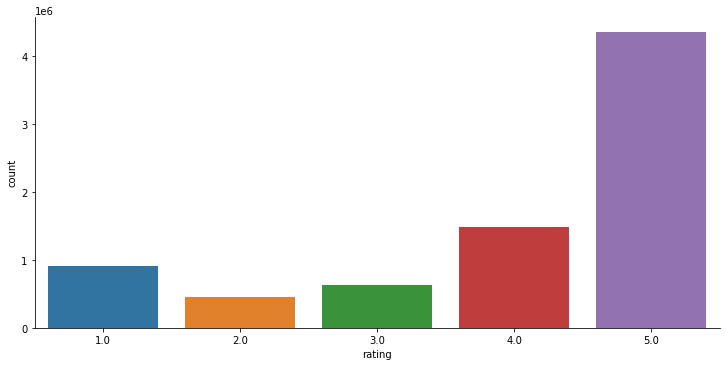

In [13]:
#Check count of each rating
sns.factorplot('rating', data =data, kind = 'count', aspect = 2.0) 
#plt.ylabel('Total Number of Ratings')

Most ratings are 5 for the products in our dataset

In [14]:
#Check number of products rated by each user

data.groupby('userID')['productID'].count().sort_values(ascending=False)

userID
A5JLAU2ARJ0BO            520
ADLVFFE4VBT8             501
A3OXHLG6DIBRW8           498
A6FIAB28IS79             431
A680RUE1FDO8B            406
                        ... 
A3AAXY0TMZS72Y             1
A3AAXX0N47FFP              1
A3AAXWHVCN6VOG             1
A3AAXWDYVQ93SZ             1
A00000262KYZUE4J55XGL      1
Name: productID, Length: 4201696, dtype: int64

Maximum number of products are rated by User - A5JLAU2ARJ0BO with products rated as 520.
There are users who have rated only 1 product.

In [15]:
#Check total ratings per product
data.groupby('productID')['userID'].count().sort_values(ascending=False)

productID
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B0058FM5IM        1
B0058FM320        1
B0058FM0M8        1
B0058FM05U        1
0132793040        1
Name: userID, Length: 476002, dtype: int64

Maximum times rated product is B0074BW614 with 18244 ratings. I also see a few products having only 1 rating.

# Popularity Based Recommendations - For New Users on the platform

In this category, I have decided to show recommendations on the basis of popularity in that country
to the new users on the platform. 
- Reason - I don't have any kind of preference data from such users

Now to calculate product popularity - I need to remove those products having less number of ratings as we can not be certain about those products without a definite number of ratings.
Example - If a product is rated only by 1 user but the rating is 5, doesn't indicate that product will be likable by other people as well.

Let's now calulate the threshold for min. number of ratings a product should have to determine its popularity.

<Figure size 1440x360 with 0 Axes>

<AxesSubplot:>

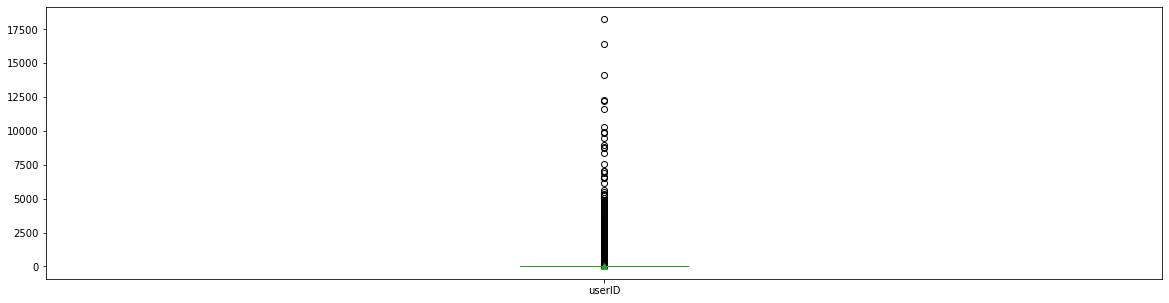

In [16]:
plt.figure(figsize=(20,5))
data.groupby('productID')['userID'].count().plot(kind='box', showfliers =True, showmeans  =True)

In [17]:
countDf = pd.DataFrame(data.groupby('productID')['userID'].count())
countDf['userID'].quantile([0,0.2,0.3,0.5,0.6,0.9,0.95,0.97,0.99,1])

0.00        1.0
0.20        1.0
0.30        1.0
0.50        2.0
0.60        3.0
0.90       25.0
0.95       55.0
0.97       92.0
0.99      246.0
1.00    18244.0
Name: userID, dtype: float64

Large proportion of data resides in last 0.01 quantile of dataset. I will filter out those products with less than 100 ratings to be sure about the popularity.

- Note: I could decide lower threshold if other slicers were available in the dataset like age, gender etc.

In [4]:
PopularityBasedDf = data.groupby('productID').filter(lambda x: x['rating'].count()>100)
PopularityBasedDf.head()

,userID,productID,rating,timestamp
183,A1BKC6B7YHYTVV,0972683275,4.0,1405382400
184,AWVFSIB42LHKJ,0972683275,4.0,1405209600
185,A36MQBNADRH8YY,0972683275,5.0,1405641600
186,A3SRXMPLAEZ6DP,0972683275,4.0,1405987200
187,A20XXTXWF2TCPY,0972683275,5.0,1405123200


In [5]:
PopularityBasedDf.drop('timestamp', axis=1, inplace = True)

<Figure size 1440x360 with 0 Axes>

<AxesSubplot:xlabel='productID'>

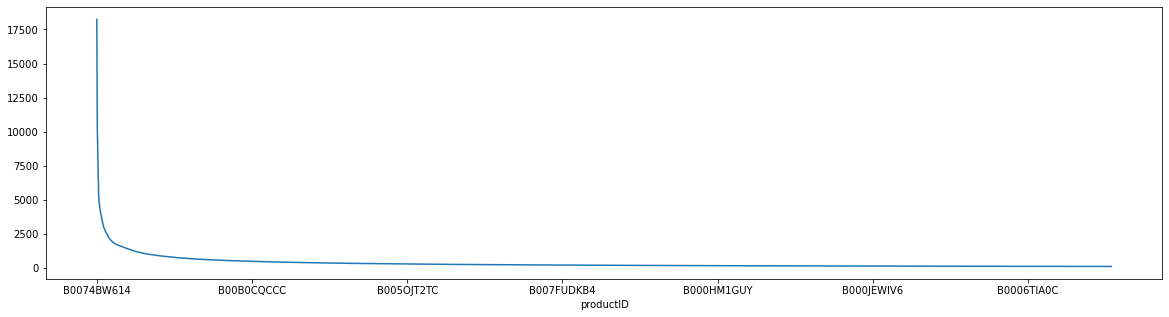

In [20]:
plt.figure(figsize=(20,5))
PopularityBasedDf.groupby('productID')['userID'].count().sort_values(ascending=False).plot(kind='line')

In [21]:
#Let's now see avg rating of products

PopularityBasedDf.groupby('productID')['rating'].mean().sort_values(ascending=False)

productID
B00GMRCAC6    4.951872
B008I6RVZU    4.951456
B00CG70K78    4.949367
B000053HC5    4.945783
B008VGCT9K    4.939130
                ...   
B003F6G6O0    1.672897
B000FMJLQC    1.633094
B0084JXKLA    1.593333
B002ZUI68G    1.588850
B000KUYTDE    1.415842
Name: rating, Length: 13077, dtype: float64

Avg ratings are distriuted in the rating bucket from 1.42 to 4.95

One way to decide most popular product is on the basis of avg rating. Top 10 recommendations can be top 10 products with most avg rating.
- But let's focus on 1 case where number of ratings provided to a product x is - 101 with avg rating as 4.5
On the other hand, there is a product y, with total number of ratings provided as 10000 and avg rating as 4.4
Now, if there are 50 such products as product x, product y will never be recommended.

Conclusion - 
1. In cases like Netflix, where we want to suggest new movies to the users - choose top 10 products from previous stage.
2. In cases like Amazon where we have the entire universe of products, go to next stage to find out top products with most number of users suggested the top rating.

In [22]:
PopularityBasedDf.groupby('productID')['userID'].count().sort_values(ascending=False)

productID
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B001MRX3RM      101
B0069R7PBA      101
B000FHFPHG      101
B00FZKC35K      101
B00198L9RA      101
Name: userID, Length: 13077, dtype: int64

<AxesSubplot:xlabel='productID'>

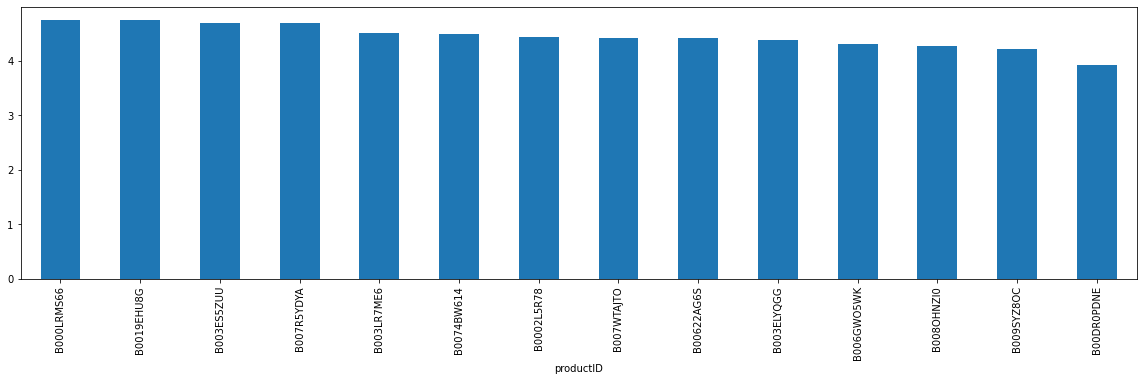

In [23]:
PopularityBasedDf.groupby('productID').filter(lambda x: ((x['userID'].count()> 8000) and (x['rating'].mode()>4.9)))[['productID','rating']].groupby('productID')['rating'].mean().sort_values(ascending=False).plot(kind = 'bar', figsize=(20,5))

# Item Based Collaborative Filtering

The idea behind this technique is that - if the user likes one item, he/she will also like similar items. 
Basically, we use historical item ratings of users to predict how they wouldrate a new item


-- Collaborative Filtering technique aims to fill the missing entries of a user-item association matrix.

There are 2 pproaches for this technique - 
1. Memory based
2. Model based

### Memory Based

Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

Points to Note:
1. If reading the data from a new file or an existing dataframe - use Reader object for Surprise to be able to parse the file or the dataframe.
 - To load a dataset from a file (e.g. a csv file), you will need the load_from_file() method.
 - To load the data from pyhton dataframe, use load_from_df() method. This dataframe should have 3 columns in order as: userID, itemID, rating.
   -- A Reader object is also required but with only rating scale

In [75]:
#pip install scikit-surprise
#conda install -c conda-forge scikit-surprise
from surprise import KNNWithMeans #Algo to use
from surprise import PredictionImpossible
from surprise import accuracy, Reader, Dataset
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.model_selection.split import PredefinedKFold

In [ ]:
#Can not use teh entire dataset because of following error:
#MemoryError: Unable to allocate 33.5 TiB for an array with shape (2144961, 2144961) and data type float64

In [69]:
PopularityBasedSubset = PopularityBasedDf[:44597]

PopularityBasedSubset.rename(columns={'rating':'raw_ratings'}, inplace=True)
PopularityBasedSubset.head()

,userID,productID,raw_ratings
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [70]:
#Reading the dataset

reader = Reader(rating_scale=(1,5))
df = Dataset.load_from_df(PopularityBasedSubset, reader)

In [71]:
#split into train and test

train_mb, test_mb = train_test_split(df, test_size = 0.3, random_state = 42)

#Train KNNWithMeans model with default parameters i.e. K(max num of neighbors to take into account) = 40 and min_k = 1 and default similarity measure - MSD

knnBase = KNNWithMeans()
knnBase.fit(train_mb)
pred_base = knnBase.test(test_mb)

#Check RMSE of Base KNNWithMeans
accuracy.rmse(pred_base, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.


RMSE: 1.2738


1.2738299739986592

In [57]:
type(train_mb)

surprise.trainset.Trainset

#Tuning with GridSearchCV
param_grid = {'k': [2, 5,10, 15,20],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }
knnTuned = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], n_jobs = -1, cv = 3)

knnTuned.fit(data)

# best RMSE score
print(knnTuned.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(knnTuned.best_params['rmse'])

In [85]:
knnTuned = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
knnTuned.fit(train_mb)

pred_base = knnTuned.test(test_mb)

#Check RMSE of Base KNNWithMeans
accuracy.rmse(pred_base, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


RMSE: 1.2659


1.265872179223411

In [86]:
pred_base

[Prediction(uid='A1WX6BYSC8VRA0', iid='B00005ATMB', r_ui=5.0, est=4.165134381907294, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3P3XDX34W00KH', iid='B00004ZCJE', r_ui=5.0, est=4.165134381907294, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1BB99EMXXUQP8', iid='B00005A1KZ', r_ui=5.0, est=4.165134381907294, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3C47XUVWK490M', iid='B00003WGP5', r_ui=5.0, est=4.232, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1VNFRX2IV0YQL', iid='B00000J3UJ', r_ui=1.0, est=4.165134381907294, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A11OZ9TC0LIL5A', iid='B00005AR4L', r_ui=1.0, est=4.165134381907294, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3QR5KBKZFDONP', iid='B00001P4ZH', r_ui=5.0, est=

### Model Based Collaborative Filtering

Advantage of this technique is that model is able to recommend a large number of items to a large number of users unlike memory based techniques

In [6]:
cf_Df = PopularityBasedDf.copy()

In [7]:
#Divide dataset into train and test
from sklearn.model_selection import train_test_split

train_cf, test_cf = train_test_split(cf_Df, test_size = 0.98, random_state = 101)

In [8]:
print(train_cf.shape, test_cf.shape)

(89181, 3) (4369898, 3)


In [9]:
train_cf = train_cf[:30000]

In [10]:
#Create a sparse pivot metric of ratings
df_reviews = train_cf.pivot(index='userID', columns = 'productID', values = 'rating').fillna(0)
df_reviews.head()

productID,0972683275,1400501466,1400532620,1400532655,140053271X,9983891212,B000001OM5,B00000DM9W,B00000J061,B00000J1EQ,...,B00IWA1MNE,B00IZBNQO8,B00J5174TU,B00J5HDEPC,B00JEGLLEA,B00JP12170,B00K4VQZCM,B00K589F8A,B00K91DB7Y,B00KFAGCUM
userID,,,,,,,,,,,,,,,,,,,,,
A0103991L4WON60DLLJR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01842741JRH81ZPEGH7V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02712303HM5RXRLNJUB7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02814502GJCMYT5QTC9T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0315785SKL63X0LCMUG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create a dummy train and dummy test dataset out of train_cf and test_cf. These datasets will be used for prediction and evaluation.

- Dummy Train will be used for prediction of those products which has not been rated by users. To ignore the products already rated by the users, mark them as 0 during prediction and products not yet rated by the users are marked as 1 for prediction.
- Dummy Test will be used for evaluation. To evaluate as we want to evaluate products which are already rated by users, we will mark them as 1. Rest will be marked as 0. 



In [13]:
test_cf = test_cf[:30000]

In [14]:
dummy_train_cf = train_cf.copy()
dummy_test_cf = test_cf.copy()

dummy_train_cf['rating'] = dummy_train_cf['rating'].apply(lambda x: 0 if x>=1 else 1)
dummy_test_cf['rating'] = dummy_test_cf['rating'].apply(lambda x: 1 if x>=1 else 0)

#Create pivot matrix for both dummy train and dummy test

dummy_train_cf = dummy_train_cf.pivot(index = 'userID', columns = 'productID', values = 'rating').fillna(1)

dummy_test_cf = dummy_test_cf.pivot(index = 'userID', columns = 'productID', values = 'rating').fillna(0)

In [15]:
dummy_train_cf.shape, dummy_test_cf.shape

((29735, 9673), (29722, 9684))

# Calculate User-User Similarity using Adjusted Cosine Similarity Method

In [110]:
df_reviews = train_cf.pivot(index='userID', columns = 'productID', values = 'rating') 
df_reviews.head()

productID,0972683275,1400501466,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,7214047977,9573212919,...,B00005A9AU,B00005A9AV,B00005AB9R,B00005ABC5,B00005AC8J,B00005AR4L,B00005ARK3,B00005ARK4,B00005ATMB,B00005ATMI
userID,,,,,,,,,,,,,,,,,,,,,
A014623426J5CM7M12MBW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01852072Z7B68UHLI5UG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A030530627MK66BD8V4LN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0478499AHWR7GZCCWR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0586418108XHQA8T1IQO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
df_reviews.T.head()

userID,A014623426J5CM7M12MBW,A01852072Z7B68UHLI5UG,A030530627MK66BD8V4LN,A0478499AHWR7GZCCWR1,A0586418108XHQA8T1IQO,A06374853B2OXBKB6H1YT,A076219533YHEV2LJO988,A07730732C0MK8X9APP6C,A0821988FXKFYX53V4QG,A08523431UFFNYIQR59LY,...,AZXWUZ9PPSOTL,AZYJE40XW6MFG,AZYQUJGXX6FV7,AZYTSU42BZ7TP,AZZ77XYX8O2WE,AZZA7IQWTXCH3,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZOFVMQC0BJG,AZZUBI2MEAHI9
productID,,,,,,,,,,,,,,,,,,,,,
0972683275,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400501466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400501776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1400532620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1400532655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
#Starts here
#Not filling NULL values here and hence calculating mean only for products rated by users
df_reviews = train_cf.pivot(index='userID', columns = 'productID', values = 'raw_ratings') 

#Rating Normalization usin mean of each rating provided by user
mean = np.nanmean(df_reviews, axis = 1)
normalized_train_df = (df_reviews.T - mean).T
normalized_train_df.head()

productID,0972683275,1400501466,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,7214047977,9573212919,...,B00005A9AU,B00005A9AV,B00005AB9R,B00005ABC5,B00005AC8J,B00005AR4L,B00005ARK3,B00005ARK4,B00005ATMB,B00005ATMI
userID,,,,,,,,,,,,,,,,,,,,,
A014623426J5CM7M12MBW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01852072Z7B68UHLI5UG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A030530627MK66BD8V4LN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0478499AHWR7GZCCWR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0586418108XHQA8T1IQO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
#Finding similairties between the users based on cosine similarity

from sklearn.metrics.pairwise import pairwise_distances

user_correlation = 1-pairwise_distances(normalized_train_df.fillna(0), metric = 'cosine')
user_correlation[np.isnan(user_correlation)]=0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Predictions

In [141]:
# Now, there can be 3 values of correlation result matrix
# -ve correlation: opposite choices of the users
# 0: no relationship between the users
# +ve: similar user choices

#As we are interested only in similar user choices to create recommendations - let's ignoring -ve correlations

user_correlation[user_correlation<0] = 0

In [142]:
user_correlation.shape  ##U*U matrix

(30294, 30294)

In [191]:
# Predict product ratings by taking a dot product of weighted sum of correlation with product rating
user_predicted_ratings = np.dot(user_correlation, df_reviews.fillna(0))
user_predicted_ratings.shape

ValueError: shapes (30294,30294) and (87074,12562) not aligned: 30294 (dim 1) != 87074 (dim 0)

In [147]:
user_predicted_ratings[user_predicted_ratings>0]

array([], dtype=float64)

In [174]:
#Since we are interested in only those ratings which are not rated by the users, we need to ignore products already rated by user

user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating.head()

NameError: name 'dummy_train' is not defined

In [ ]:
#Finding top 5 recommendations for user1

user_final_rating.iloc[1].sort_values(ascending=False)[0:5]

In [176]:
#As we see ratings provided by the model are beyond our rating scale. To get them into the sacle, let's use MinMax scalar

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X = user_final_rating.copy() #Creating a backup
X = X[X>0]
scalar = MinMaxScalar(feature_range = (1,5))
corrected_rating_X = scalar.fit_transform(X)

NameError: name 'user_final_rating' is not defined

# Item Based Collaborative Filtering

In [27]:
#Item should be in the row and user id as column

df_reviews_ib = train_cf.pivot(index='userID', columns = 'productID', values = 'rating').T

In [28]:
#Data Normalization -- why??
mean = np.nanmean(df_reviews_ib, axis =1)
normalized_train_df_ib = (df_reviews_ib.T - mean).T

In [29]:
#Calculate Item-Item Similarity
from sklearn.metrics.pairwise import pairwise_distances

item_correlation = 1-pairwise_distances(normalized_train_df_ib.fillna(0), metric = 'cosine')
item_correlation[np.isnan(item_correlation)] = 0
item_correlation[item_correlation<0]=0

In [32]:
item_correlation.shape, df_reviews_ib.T.shape

((9673, 9673), (29735, 9673))

In [33]:
#Prediction - Dot product of I-I correlation and pivot matrix

train_prediction_ib = np.dot(df_reviews_ib.fillna(0).T, item_correlation)
train_prediction_ib

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
train_prediction_ib[train_prediction_ib>0]

array([5., 5., 4., ..., 5., 4., 5.])

In [35]:
train_prediction_ib.shape

(29735, 9673)

In [36]:
dummy_train_cf.shape

(29735, 9673)

In [38]:
#Recommendation

item_train_final_rating = np.multiply(train_prediction_ib,dummy_train_cf)
item_train_final_rating.head()

productID,0972683275,1400501466,1400532620,1400532655,140053271X,9983891212,B000001OM5,B00000DM9W,B00000J061,B00000J1EQ,...,B00IWA1MNE,B00IZBNQO8,B00J5174TU,B00J5HDEPC,B00JEGLLEA,B00JP12170,B00K4VQZCM,B00K589F8A,B00K91DB7Y,B00KFAGCUM
userID,,,,,,,,,,,,,,,,,,,,,
A0103991L4WON60DLLJR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01842741JRH81ZPEGH7V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02712303HM5RXRLNJUB7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02814502GJCMYT5QTC9T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0315785SKL63X0LCMUG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
#Top 5 recommendations for user 10
item_train_final_rating.iloc[5].sort_values(ascending=False)[0:5]

productID
B00KFAGCUM    0.0
B002A6H72Q    0.0
B002A63QOE    0.0
B002A1MLV8    0.0
B0029ZA78O    0.0
Name: A03414512XSRNHZK91OMU, dtype: float64

In [56]:
#Evaluation
test_reviews_Df = test_cf.pivot(index='userID', columns= 'productID', values = 'rating').T

In [58]:
#Data Normalization
mean = np.nanmean(test_reviews_Df, axis = 1)
test_normalized_df_ib = (test_reviews_Df.T-mean).T

#item-item similarity
test_item_correlation_df = 1-pairwise_distances(test_normalized_df_ib.fillna(0), metric = 'cosine')
test_item_correlation_df[np.isnan(test_item_correlation_df)]=0
test_item_correlation_df[test_item_correlation_df<0]=0

In [60]:
test_item_correlation_df.shape, test_reviews_Df.shape

((9684, 9684), (9684, 29722))

In [62]:
#Predict ratings of test dataset
test_prediction_ib = (np.dot(test_item_correlation_df, test_reviews_Df.fillna(0))).T

In [63]:
#FOR EVALUATION - we want only those products which are already evaluated
test_item_final_rating_ib = np.multiply(test_prediction_ib,dummy_test_cf)
test_item_final_rating_ib.head()

productID,0972683275,1400501466,1400501776,1400532620,1400532655,140053271X,1400599997,9573212919,9575871979,9625993428,...,B00J3H1P7S,B00J46VVKE,B00JDAIMQ2,B00JEGLLEA,B00JP12170,B00K0OBEE2,B00K4VQZCM,B00K589F8A,B00K91DB7Y,B00KFAGCUM
userID,,,,,,,,,,,,,,,,,,,,,
A001010037M4OWK2XR8MO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00277003AGRC9WJJ555O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00915532FY7K50HBPEIM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01037873UQRDOUGJHATT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01410041ZE038XXVXLBB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
test_ = test_cf.pivot(index='userID', columns= 'productID', values = 'rating')

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X = test_item_final_rating_ib.copy()
X = X[X>0]
#Rating re-scaling
scaler = MinMaxScaler(feature_range=(1,5))
y = scaler.fit_transform(X)

#Find total nan values
total_non_nan = np.count_nonzero(~np.isnan(y))

In [68]:
y.shape, test_.shape

((29722, 9684), (29722, 9684))

In [69]:
#Find RMSE
rmse = (sum(sum((test_ - y)**2))/total_non_nan)**0.5
rmse

0.9801053002133768

Steps:

1. Create pivot matrix
2. Data Normalization
3. Calculate User-User or Item-Item Similarity
			1-pairwise_distances(test_normalized_df_ib.fillna(0), metric = 'cosine')
		- Replace with 0 whereever correlation is np.NaN or -ve
4. Prediction: Dot product of correlation metric with pivot table (with fillna as 0).T (transpose for item item correlation)
		np.dot(df_reviews_ib.fillna(0).T, item_correlation)  -- oRDER IS IMP
5. Recommendation: Find ratings of only those items which are not rated by users already - np.multiple prediction with dummy train
		np.multiply(train_prediction_ib,dummy_train_cf)
		

